## 0. Importation des modules et des fichiers


In [3]:
import datetime

import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
# from yellowbrick.cluster import KElbowVisualizer

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from scipy.optimize import minimize, fmin_slsqp
from sklearn.metrics import mean_squared_error

In [4]:
df_svi = pd.read_excel('COVID-19 Community Vulnerability Index (CCVI).xlsx', sheet_name = 'County CCVI')

df_svi = df_svi.sort_values(by = ['State', 'County'])
df_svi = df_svi.reset_index(drop = True)

In [5]:
df_svi

,State,State Abbreviation,County,FIPS (5-digit),THEME 1: Socioeconomic Status,THEME 2:\nHousehold Composition & Disability,THEME 3: \nMinority Status & Language,THEME 4: \nHousing Type & Transportation,THEME 5: Epidemiological Factors,THEME 6: Healthcare System Factors,CCVI SCORE\nHigher = More Vulnerable
0,Alabama,AL,Autauga,1001,0.356574,0.566380,0.591531,0.314231,0.832537,0.976441,0.803566
1,Alabama,AL,Baldwin,1003,0.240369,0.244190,0.432028,0.335244,0.380452,0.727157,0.375677
2,Alabama,AL,Barbour,1005,0.972939,0.838586,0.897167,0.640242,0.777778,0.851958,0.985992
3,Alabama,AL,Bibb,1007,0.746259,0.248647,0.443489,0.743394,0.725883,0.971665,0.803247
4,Alabama,AL,Blount,1009,0.635148,0.432346,0.583254,0.322190,0.630054,0.935371,0.773002
...,...,...,...,...,...,...,...,...,...,...,...
3137,Wyoming,WY,Sweetwater,56037,0.270296,0.241961,0.660936,0.452085,0.023241,0.025151,0.057625
3138,Wyoming,WY,Teton,56039,0.003502,0.004776,0.832219,0.890799,0.013372,0.025788,0.007641
3139,Wyoming,WY,Uinta,56041,0.392232,0.601082,0.438077,0.890162,0.019421,0.026743,0.120662
3140,Wyoming,WY,Washakie,56043,0.495065,0.756129,0.425661,0.746259,0.214263,0.092327,0.217128


# Méthode du synthetic control pour mesurer l'effet des "incentives" à la vaccination aux États-Unis

In [6]:
path = 'COVID-19_Vaccinations_in_the_United_States_County.csv'
df_global = pd.read_csv(path, sep=',' )

/opt/homebrew/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## 1. Définitions et traitement des données

In [7]:
states = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
           'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
           'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
           'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
           'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

states_names = {"AL":"Alabama", "AK":"Alaska", "AZ":"Arizona", "AR":"Arkansas",
                "CA":"California", "CO":"Colorado", "CT":"Connecticut",
                "DE":"Delaware", "FL":"Florida", "GA":"Georgia", "HI":"Hawaii",
                "ID":"Idaho", "IL":"Illinois", "IN":"Indiana", "IA":"Iowa",
                "KS":"Kansas", "KY":"Kentucky", "LA":"Louisiana", "ME":"Maine",
                "MD":"Maryland", "MA":"Massachusetts", "MI":"Michigan",
                "MN":"Minnesota", "MS":"Mississippi", "MO":"Missouri", "MT":"Montana",
                "NE":"Nebraska", "NV":"Nevada", "NH":"New Hampshire", "NJ":"New Jersey",
                "NM":"New Mexico", "NY":"New York", "NC":"North Carolina",
                "ND":"North Dakota", "OH":"Ohio", "OK":"Oklahoma", "OR":"Oregon",
                "PA":"Pennsylvania", "RI":"Rhode Island", "SC":"South Carolina",
                "SD":"South Dakota", "TN":"Tennessee", "TX":"Texas", "UT":"Utah",
                "VT":"Vermont", "VA":"Virginia", "WA":"Washington", "WV":"West Virginia",
                "WI":"Wisconsin", "WY":"Wyoming"}

In [8]:
df_global['State'] = df_global['Recip_State'].map(states_names)

df_global = df_global.sort_values(by = ['State', 'Recip_County'])
df_global.drop(df_global.loc[(df_global['FIPS'] == "UNK")].index, inplace=True)
df_global = df_global.reset_index(drop = True)

In [9]:
df_global["FIPS"] = df_global["FIPS"].astype(int)

In [10]:
# Importation des données de vaccination

counties_fips = list(set(df_global["FIPS"].to_list())) # Extraction des FIPS pour créer une clé (State, County)

df_counties = {}

for X in counties_fips:
    df_current_fips = df_global.loc[df_global['FIPS'] == X].copy()
    df_current_fips = df_current_fips.loc[::-1].reset_index(drop=True)
    current_state,current_county = df_current_fips["Recip_State"][0],df_current_fips["Recip_County"][0]
    df_counties[(current_county,current_state,X)] = df_current_fips

In [11]:
#la liste ci-dessous contient les couples comtés-états-fips et le dictionnaire associé à pour valeurs les dataframes avec comme clés ces couples
counties = list(df_counties.keys())
len(counties)

3224

In [12]:
map_dictionary = {}

for X in counties : 
    map_dictionary[X[1]] = X[0]

In [13]:
census_list = ['Census2019_5PlusPop', 'Census2019_5to17Pop', 'Census2019_12PlusPop',
       'Census2019_18PlusPop', 'Census2019_65PlusPop']

tf = len(df_counties[counties[0]])

for X in df_counties:
    if X[0] == 'Unknown County':
        counties.remove(X)        

for census in census_list:
    for X in counties:
        df_counties[X][census] = df_counties[X][census][tf-1]

In [14]:
# On sélectionnera ici la catégorie d'âge souhaitée en choissant les bornes du jeu de données:
# Acceptable lower bounds : '12', '18', '65' 
# Acceptable upper bounds : '18', '65', 'inf'
# Acceptable vaccinal schemes : 'Administered_Dose1_Recip', 'Series_Complete'

df_counties_cond = {}

def cat_age_vax(lb,ub,vax_scheme):
    for X in counties:
        if ub != "_InfPlus":
            df_current_county = df_counties[X].copy()
            df_current_county[vax_scheme+'_'+lb+'to'+ub] = df_current_county[vax_scheme+'_'+lb+'Plus'] - df_current_county[vax_scheme+'_'+ub+'Plus']
            df_current_county['Census2019_'+lb+'to'+ub+'Pop'] = df_current_county['Census2019_'+lb+'PlusPop'] - df_current_county['Census2019_'+ub+'PlusPop']
            df_current_county[vax_scheme+'_'+lb+'to'+ub+'Pop_Pct'] = df_current_county[vax_scheme+'_'+lb+'to'+ub]*100/df_current_county['Census2019_'+lb+'to'+ub+'Pop']
            df_counties_cond[X] = df_current_county[["Date",vax_scheme+'_'+lb+'to'+ub+'Pop_Pct',vax_scheme+'_'+lb+'to'+ub,'Census2019_'+lb+'to'+ub+'Pop']]
        else : 
            df_counties_cond[X] = df_current_county[["Date",vax_scheme+'_'+lb+'PlusPop_Pct',vax_scheme+'_'+lb+'Plus','Census2019_'+lb+'PlusPop']]
        df_counties_cond[X].set_axis(['Date', 'Pct', 'Dose' ,'Census'], axis='columns', inplace=True)

In [15]:
cat_age_vax('18','65','Administered_Dose1_Recip')

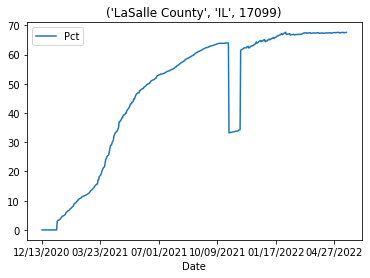

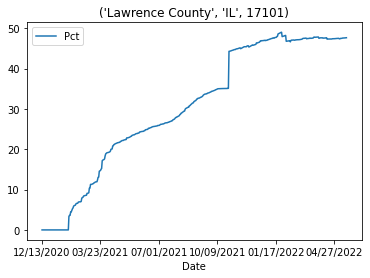

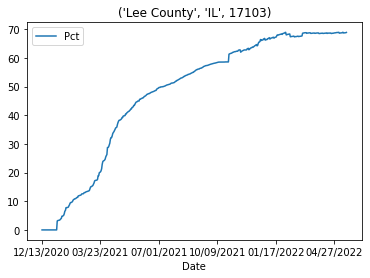

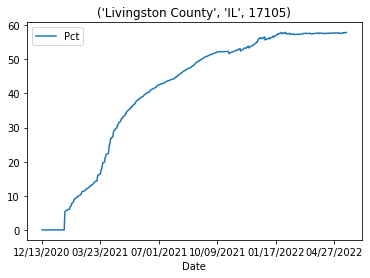

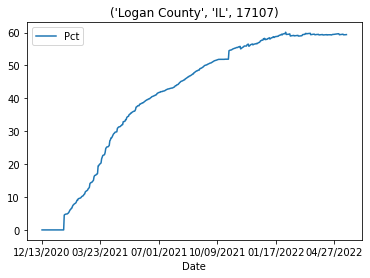

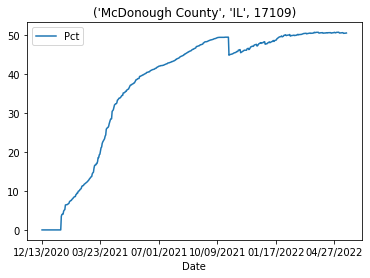

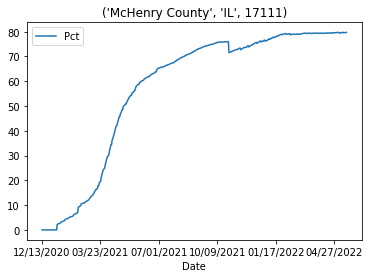

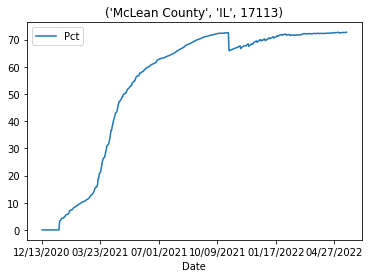

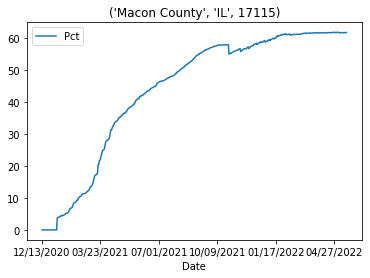

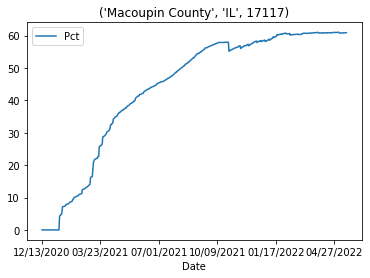

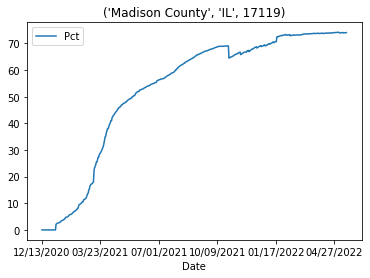

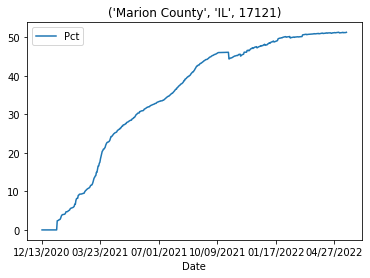

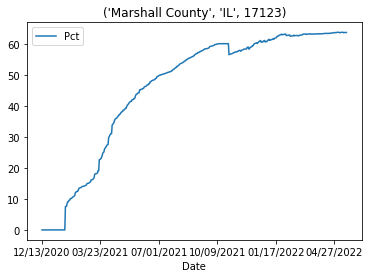

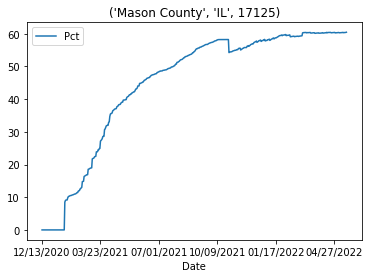

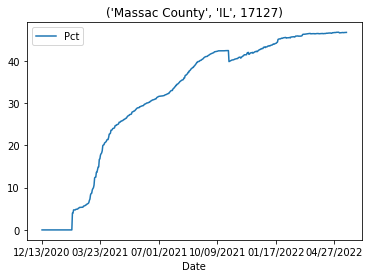

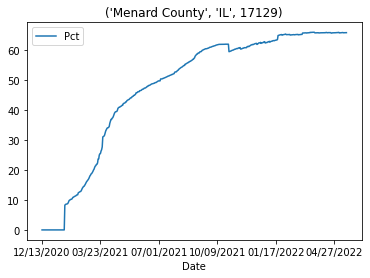

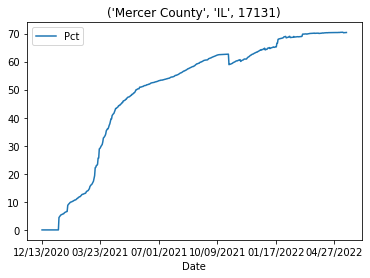

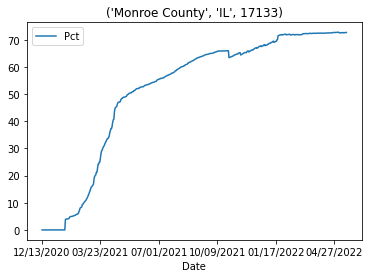

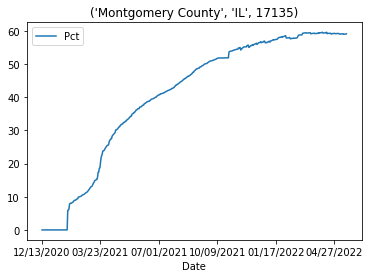

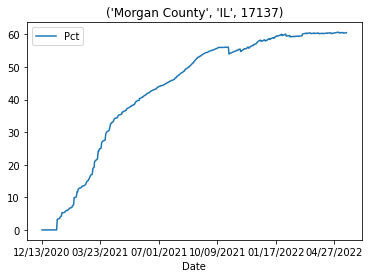

In [16]:
for k in range(100,120):
    df_counties_cond[counties[k+10]].plot(x='Date', y='Pct',title=str(counties[k+10]))

In [17]:
# On remarque qu'il y a des soucis dans le report des doses administrées : il arrive que le pourcentage de doses
# administrées diminue, alors qu'il ne devrait qu'augmenter ou rester constant (cf. explications dans le rapport)
# On décide donc de remédier à ces erreurs en fixant un seuil pour éviter que les données ne diminuent
# Dans un second temps, on effectue une interpolation sur la période où l'on constate des erreurs de report


tf = len(df_counties_cond[counties[0]])

print(len(counties))

k=0
for X in counties:
    if X in df_counties_cond :
        k+=1
        print(X,' ',k)
        for t in range(1,tf):
            if df_counties_cond[X]['Pct'].loc[t] < df_counties_cond[X][('Pct')].loc[t-1] or np.isnan(df_counties_cond[X]['Pct'].loc[t]):
                #on a un souci à partir du temps t
                j = t
                flag = True
                while j < tf and flag:
                    if df_counties_cond[X]['Pct'].loc[j] >= df_counties_cond[X]['Pct'].loc[t-1]:
                        #on a trouvé le plus petit indice pour lequel les données redeviennent cohérentes
                        a_t = df_counties_cond[X]['Pct'].loc[t-1]
                        a_j = df_counties_cond[X]['Pct'].loc[j]
                        
                        #on interpole linéairement
                        for i in range(t,j):
                            df_counties_cond[X]['Pct'].loc[i] = ((a_t-a_j)/(t-1-j))*(i-j) + a_j
                        flag = False
                    j +=1 
                        
                if flag:
                    #on a pas trouvé de plus petit indice: on crée un plateau à partir du temps t
                    for i in range(t,tf):
                        df_counties_cond[X]['Pct'].loc[i] = df_counties_cond[X][('Pct')].loc[t-1]

3224
('Baker County', 'OR', 41001)   1
('Benton County', 'OR', 41003)   2
('Clackamas County', 'OR', 41005)   3
('Clatsop County', 'OR', 41007)   4
('Columbia County', 'OR', 41009)   5
('Coos County', 'OR', 41011)   6
('Crook County', 'OR', 41013)   7
('Curry County', 'OR', 41015)   8
('Deschutes County', 'OR', 41017)   9
('Douglas County', 'OR', 41019)   10
('Gilliam County', 'OR', 41021)   11
('Grant County', 'OR', 41023)   12
('Harney County', 'OR', 41025)   13
('Hood River County', 'OR', 41027)   14
('Jackson County', 'OR', 41029)   15
('Jefferson County', 'OR', 41031)   16
('Josephine County', 'OR', 41033)   17
('Klamath County', 'OR', 41035)   18
('Lake County', 'OR', 41037)   19
('Lane County', 'OR', 41039)   20
('Lincoln County', 'OR', 41041)   21
('Linn County', 'OR', 41043)   22
('Malheur County', 'OR', 41045)   23


/opt/homebrew/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


('Marion County', 'OR', 41047)   24
('Morrow County', 'OR', 41049)   25
('Multnomah County', 'OR', 41051)   26
('Polk County', 'OR', 41053)   27
('Sherman County', 'OR', 41055)   28
('Tillamook County', 'OR', 41057)   29
('Umatilla County', 'OR', 41059)   30
('Union County', 'OR', 41061)   31
('Wallowa County', 'OR', 41063)   32
('Wasco County', 'OR', 41065)   33
('Washington County', 'OR', 41067)   34
('Wheeler County', 'OR', 41069)   35
('Yamhill County', 'OR', 41071)   36
('Belknap County', 'NH', 33001)   37
('Carroll County', 'NH', 33003)   38
('Cheshire County', 'NH', 33005)   39
('Coos County', 'NH', 33007)   40
('Grafton County', 'NH', 33009)   41
('Hillsborough County', 'NH', 33011)   42
('Merrimack County', 'NH', 33013)   43
('Rockingham County', 'NH', 33015)   44
('Strafford County', 'NH', 33017)   45
('Sullivan County', 'NH', 33019)   46
('Barnstable County', 'MA', 25001)   47
('Berkshire County', 'MA', 25003)   48
('Bristol County', 'MA', 25005)   49
('Dukes County', 'MA', 

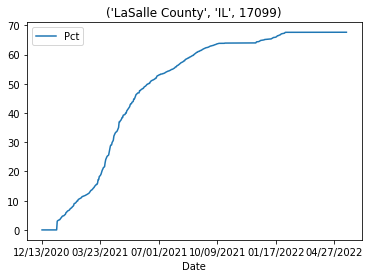

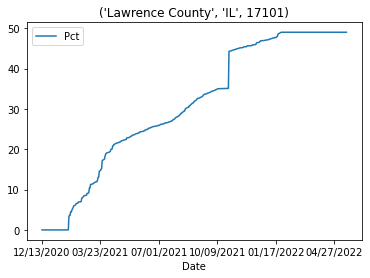

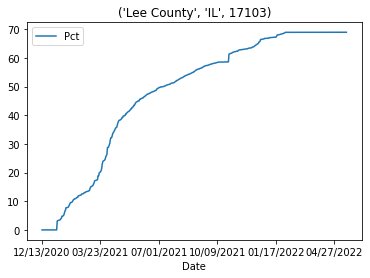

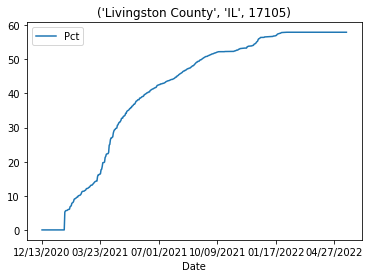

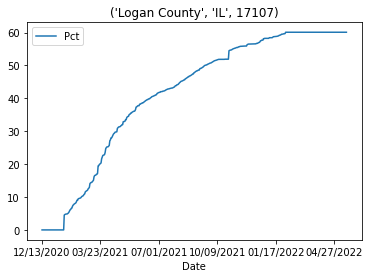

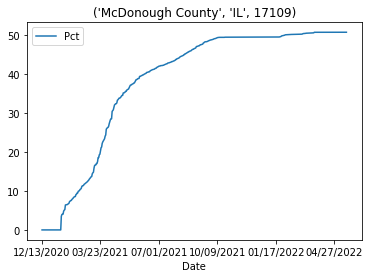

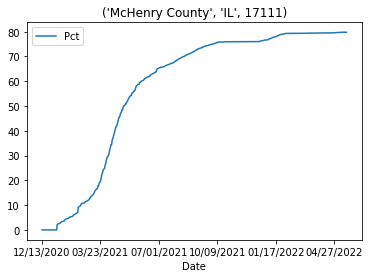

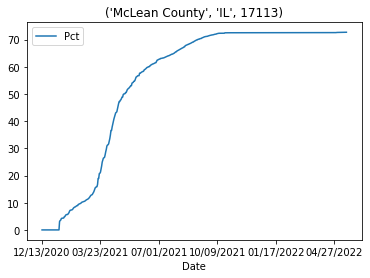

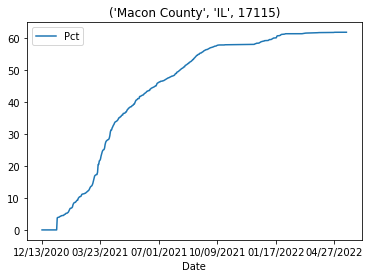

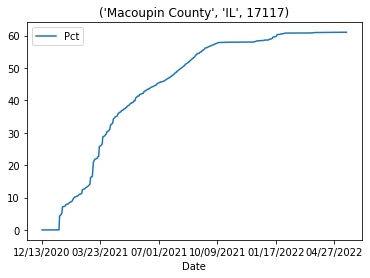

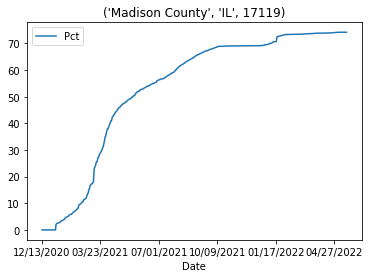

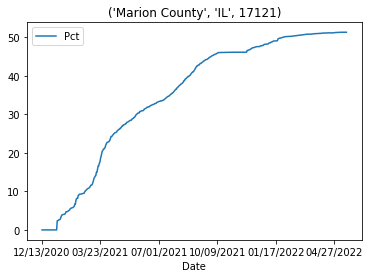

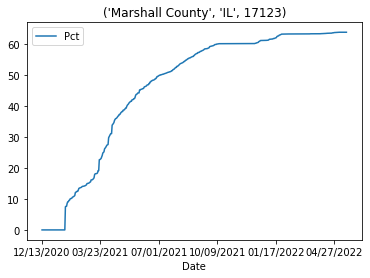

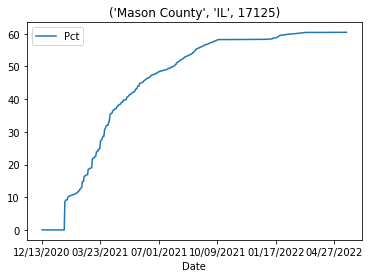

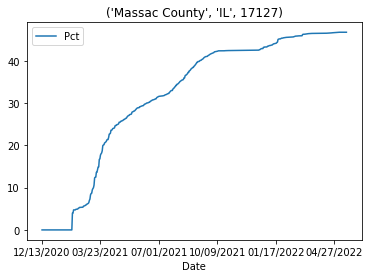

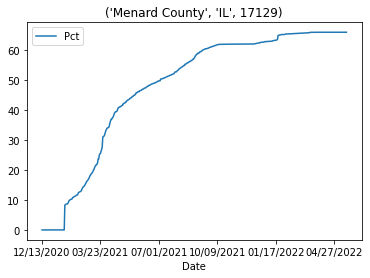

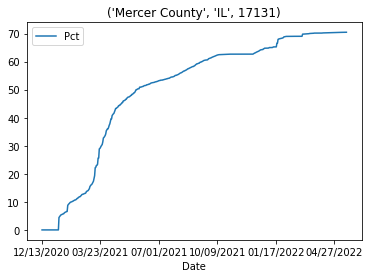

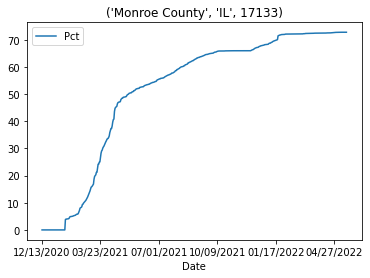

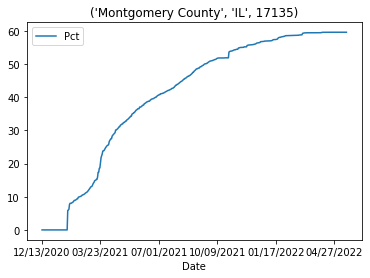

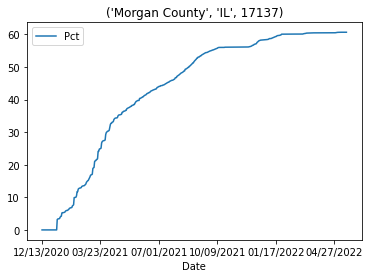

In [18]:
for k in range(100,120):
    df_counties_cond[counties[k+10]].plot(x='Date', y='Pct',title=str(counties[k+10]))

In [19]:
# Comparaison des comtés des counties et df_svi

counties_bis = []
fips_bis = []

for X in counties : 
    if X[2] in list(df_svi['FIPS (5-digit)']):
        counties_bis.append(X)
        fips_bis.append(X[2])
    else : 
        df_svi.drop(df_svi.loc[(df_svi['FIPS (5-digit)'] == X[2])].index, inplace=True)

for k in range(len(df_svi)): 
    print((df_svi.loc[k,"County"],df_svi.loc[k,"State Abbreviation"],df_svi.loc[k,'FIPS (5-digit)']))
    current_fips = df_svi.loc[k,'FIPS (5-digit)']
    if current_fips not in fips_bis : 
        df_svi.drop(k,0,inplace = True)

('Autauga', 'AL', 1001)
('Baldwin', 'AL', 1003)
('Barbour', 'AL', 1005)
('Bibb', 'AL', 1007)
('Blount', 'AL', 1009)
('Bullock', 'AL', 1011)
('Butler', 'AL', 1013)
('Calhoun', 'AL', 1015)
('Chambers', 'AL', 1017)
('Cherokee', 'AL', 1019)
('Chilton', 'AL', 1021)
('Choctaw', 'AL', 1023)
('Clarke', 'AL', 1025)
('Clay', 'AL', 1027)
('Cleburne', 'AL', 1029)
('Coffee', 'AL', 1031)
('Colbert', 'AL', 1033)
('Conecuh', 'AL', 1035)
('Coosa', 'AL', 1037)
('Covington', 'AL', 1039)
('Crenshaw', 'AL', 1041)
('Cullman', 'AL', 1043)
('Dale', 'AL', 1045)
('Dallas', 'AL', 1047)
('DeKalb', 'AL', 1049)
('Elmore', 'AL', 1051)
('Escambia', 'AL', 1053)
('Etowah', 'AL', 1055)
('Fayette', 'AL', 1057)
('Franklin', 'AL', 1059)
('Geneva', 'AL', 1061)
('Greene', 'AL', 1063)
('Hale', 'AL', 1065)
('Henry', 'AL', 1067)
('Houston', 'AL', 1069)
('Jackson', 'AL', 1071)
('Jefferson', 'AL', 1073)
('Lamar', 'AL', 1075)
('Lauderdale', 'AL', 1077)
('Lawrence', 'AL', 1079)
('Lee', 'AL', 1081)
('Limestone', 'AL', 1083)
('Lownde

In [20]:
counties = counties_bis

In [21]:
df_counties_cond

{('Baker County',
  'OR',
  41001):            Date        Pct    Dose  Census
 0    12/13/2020   0.000000     0.0  8661.0
 1    12/14/2020   0.000000     0.0  8661.0
 2    12/15/2020   0.000000     0.0  8661.0
 3    12/16/2020   0.000000     0.0  8661.0
 4    12/17/2020   0.000000     0.0  8661.0
 ..          ...        ...     ...     ...
 517  05/14/2022  91.686872  7941.0  8661.0
 518  05/15/2022  91.686872  7941.0  8661.0
 519  05/16/2022  91.686872  7941.0  8661.0
 520  05/17/2022  91.698418  7942.0  8661.0
 521  05/18/2022  91.698418  7942.0  8661.0
 
 [522 rows x 4 columns],
 ('Benton County',
  'OR',
  41003):            Date        Pct     Dose   Census
 0    12/13/2020   0.000000      0.0  62401.0
 1    12/14/2020   0.000000      0.0  62401.0
 2    12/15/2020   0.000000      0.0  62401.0
 3    12/16/2020   0.000000      0.0  62401.0
 4    12/17/2020   0.000000      0.0  62401.0
 ..          ...        ...      ...      ...
 517  05/14/2022  83.836797  52315.0  62401.0
 518  

In [22]:
# On enlève les comtés dont on n'a pas les données du census :

for X in counties:
    if X in df_counties_cond:
        if sum(df_counties_cond[X]['Census'].isnull()) == len(df_counties_cond[X]):
            del(df_counties_cond[X])
            counties.remove(X)
    else:
        counties.remove(X)

In [23]:
df_svi

,State,State Abbreviation,County,FIPS (5-digit),THEME 1: Socioeconomic Status,THEME 2:\nHousehold Composition & Disability,THEME 3: \nMinority Status & Language,THEME 4: \nHousing Type & Transportation,THEME 5: Epidemiological Factors,THEME 6: Healthcare System Factors,CCVI SCORE\nHigher = More Vulnerable
0,Alabama,AL,Autauga,1001,0.356574,0.566380,0.591531,0.314231,0.832537,0.976441,0.803566
1,Alabama,AL,Baldwin,1003,0.240369,0.244190,0.432028,0.335244,0.380452,0.727157,0.375677
2,Alabama,AL,Barbour,1005,0.972939,0.838586,0.897167,0.640242,0.777778,0.851958,0.985992
3,Alabama,AL,Bibb,1007,0.746259,0.248647,0.443489,0.743394,0.725883,0.971665,0.803247
4,Alabama,AL,Blount,1009,0.635148,0.432346,0.583254,0.322190,0.630054,0.935371,0.773002
...,...,...,...,...,...,...,...,...,...,...,...
3137,Wyoming,WY,Sweetwater,56037,0.270296,0.241961,0.660936,0.452085,0.023241,0.025151,0.057625
3138,Wyoming,WY,Teton,56039,0.003502,0.004776,0.832219,0.890799,0.013372,0.025788,0.007641
3139,Wyoming,WY,Uinta,56041,0.392232,0.601082,0.438077,0.890162,0.019421,0.026743,0.120662
3140,Wyoming,WY,Washakie,56043,0.495065,0.756129,0.425661,0.746259,0.214263,0.092327,0.217128


In [24]:
df_svi = df_svi.reset_index(drop = True)

In [25]:
df_counties_cond_copy = df_counties_cond.copy()

for X in df_counties_cond_copy.keys():
    if X not in counties : 
        del df_counties_cond[X]

In [26]:
len(counties) == len(df_counties_cond)

True

In [27]:
len(counties) == len(df_svi)

True

In [28]:
len(df_counties_cond)

3142

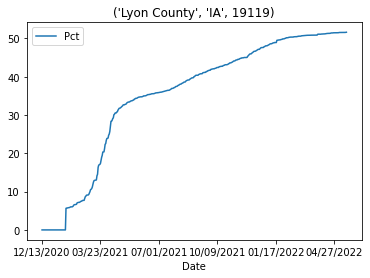

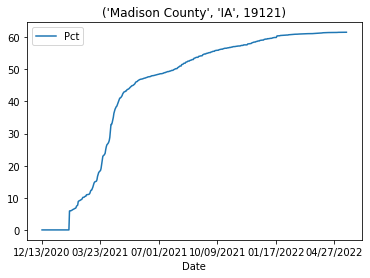

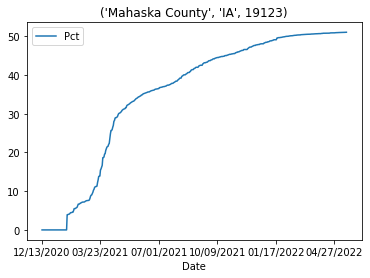

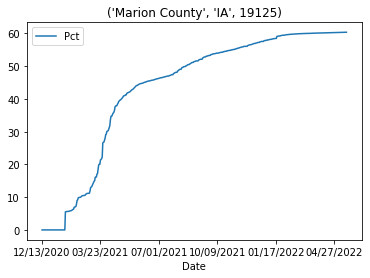

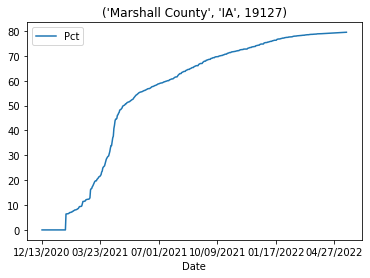

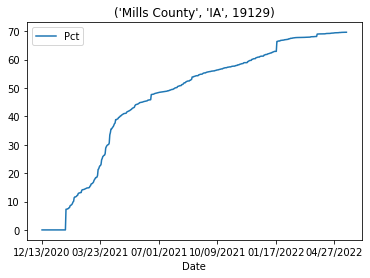

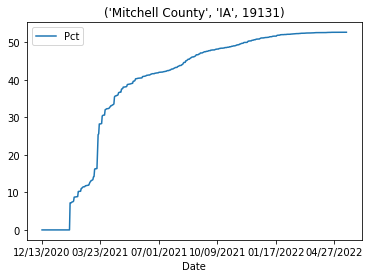

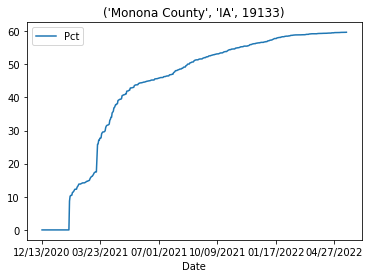

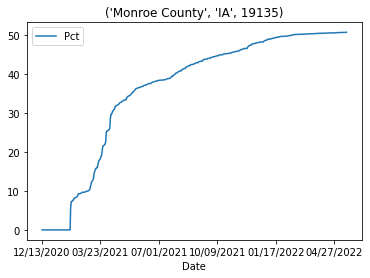

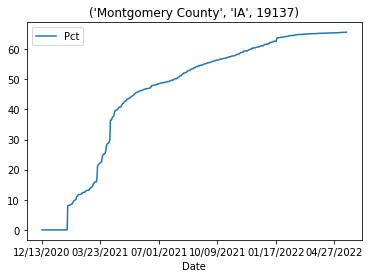

In [29]:
for k in range(10):
    df_counties_cond[counties[k+900]].plot(x='Date', y='Pct',title=str(counties[k+900]))

### Paramètres

In [30]:
# Pour plus de simplicité, on renomme le dataframe : 

df = df_counties_cond.copy()

In [31]:
# En fonction du type de dose et de la catégorie d'âge choisie, on a notre "response variable" 
# que l'on cherche à modéliser après l'intervention.

df_vax = {}
for X in counties: 
    df_vax[X] = df[X]['Pct']

ls_vax = {}
for X in counties:
    ls_vax[X] = df_vax[X].to_numpy()

In [32]:
df_svi.columns

Index(['State', 'State Abbreviation', 'County', 'FIPS (5-digit)',
       'THEME 1: Socioeconomic Status',
       'THEME 2:\nHousehold Composition & Disability',
       'THEME 3: \nMinority Status & Language',
       'THEME 4: \nHousing Type & Transportation',
       'THEME 5: Epidemiological Factors',
       'THEME 6: Healthcare System Factors',
       'CCVI SCORE\nHigher = More Vulnerable'],
      dtype='object')

In [33]:
df_svi_prm = df_svi.copy()
county_vector = {}
for X in counties :
    county_vector[X] = df_svi.loc[(df_svi['State Abbreviation']==X[1]) & (df_svi['FIPS (5-digit)'] == X[2]),['THEME 1: Socioeconomic Status',
       'THEME 2:\nHousehold Composition & Disability',
       'THEME 3: \nMinority Status & Language',
       'THEME 4: \nHousing Type & Transportation',
       'THEME 5: Epidemiological Factors',
       'THEME 6: Healthcare System Factors']].values[0]

In [34]:
county_vector

{('Baker County',
  'OR',
  41001): array([0.63482967, 0.69213626, 0.32187202, 0.78892073, 0.84463547,
        0.2330468 ]),
 ('Benton County',
  'OR',
  41003): array([0.3008596 , 0.03056351, 0.66539319, 0.5084368 , 0.91308501,
        0.25469596]),
 ('Clackamas County',
  'OR',
  41005): array([0.10665393, 0.12034384, 0.64501751, 0.40210124, 0.06749443,
        0.30881885]),
 ('Clatsop County',
  'OR',
  41007): array([0.33237822, 0.62941738, 0.56829035, 0.74180197, 0.14581343,
        0.32187202]),
 ('Columbia County',
  'OR',
  41009): array([0.4629099 , 0.46959567, 0.38713785, 0.50557147, 0.13849093,
        0.53613499]),
 ('Coos County',
  'OR',
  41011): array([0.67812799, 0.81216173, 0.39605221, 0.93027698, 0.21903852,
        0.19293219]),
 ('Crook County',
  'OR',
  41013): array([0.69468322, 0.88888889, 0.41228908, 0.82139446, 0.14262974,
        0.4438077 ]),
 ('Curry County',
  'OR',
  41015): array([0.57561286, 0.51862464, 0.40910538, 0.84081503, 0.03215536,
        0.437

In [35]:
# Normalisation et moyenne à 0
df_svi_prm = df_svi.drop(columns = [ 'State', 'County', 'State Abbreviation','FIPS (5-digit)','CCVI SCORE\nHigher = More Vulnerable'])
df_prm_scaled = (df_svi_prm-df_svi_prm.mean())/df_svi_prm.std()

county_vector_scaled = {}
for X in counties : 
    county_vector_scaled[X] = df_prm_scaled.loc[(df_svi['State Abbreviation']==X[1]) & (df_svi['FIPS (5-digit)'] == X[2]),].values[0]


In [36]:
county_vector_scaled

{('Baker County',
  'OR',
  41001): array([ 0.46754167,  0.66526325, -0.61674878,  1.00037686,  1.19328243,
        -0.92429652]),
 ('Benton County',
  'OR',
  41003): array([-0.68917942, -1.6253981 ,  0.57266676,  0.02921415,  1.43028541,
        -0.84933804]),
 ('Clackamas County',
  'OR',
  41005): array([-1.3618199 , -1.31453838,  0.50211755, -0.33896785, -1.49752811,
        -0.66194183]),
 ('Clatsop County',
  'OR',
  41007): array([-0.58001318,  0.44810239,  0.23645569,  0.83723034, -1.22635262,
        -0.61674628]),
 ('Columbia County',
  'OR',
  41009): array([-0.12791056, -0.10527201, -0.39077086,  0.01929308, -1.25170642,
         0.12512225]),
 ('Coos County',
  'OR',
  41011): array([ 0.61750742,  1.08084522, -0.35990558,  1.4898164 , -0.97281455,
        -1.06319018]),
 ('Crook County',
  'OR',
  41013): array([ 0.67484727,  1.34650903, -0.30368668,  1.11281567, -1.23737601,
        -0.19455364]),
 ('Curry County',
  'OR',
  41015): array([ 0.26244146,  0.06448826, -0.31

In [37]:
# Matrice des corrélations

df_prm_corr = df_prm_scaled.corr()
df_prm_corr.head()

,THEME 1: Socioeconomic Status,THEME 2:\nHousehold Composition & Disability,THEME 3: \nMinority Status & Language,THEME 4: \nHousing Type & Transportation,THEME 5: Epidemiological Factors,THEME 6: Healthcare System Factors
THEME 1: Socioeconomic Status,1.000000,0.629442,0.227265,0.473983,0.278168,0.299330
THEME 2:\nHousehold Composition & Disability,0.629442,1.000000,-0.068607,0.346980,0.248809,0.156631
THEME 3: \nMinority Status & Language,0.227265,-0.068607,1.000000,0.201259,-0.095143,0.011495
THEME 4: \nHousing Type & Transportation,0.473983,0.346980,0.201259,1.000000,-0.033465,0.006933
THEME 5: Epidemiological Factors,0.278168,0.248809,-0.095143,-0.033465,1.000000,0.154033


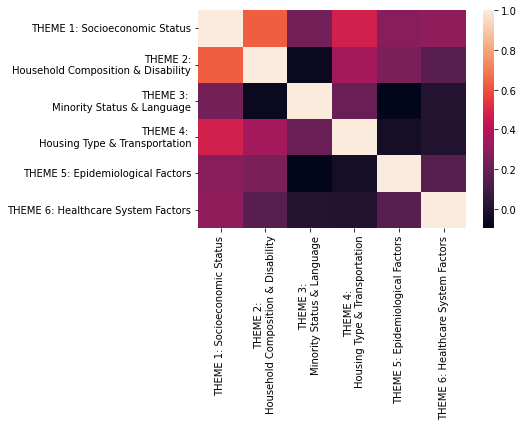

In [38]:
sns.heatmap(df_prm_corr);


In [39]:
# Définitions des états traités 

target_states_all = ['AL', 'AR', 'CA', 'CO', 'CT', 'DE', 'IL', 'ID', 'KY', 'ME', 'MD',
                'MI', 'MN', 'NJ', 'NY', 'OH', 'OR', 'WV']

control_states_all = []
for X in states:
  if X not in target_states_all:
    control_states_all.append(X)

In [40]:
# Définition des comtés traités : 

target_counties_all = []
control_counties_all = []
for X in counties : 
    if X[1] in target_states_all:
        target_counties_all.append(X)
    if X[1] in control_states_all:
        control_counties_all.append(X)

print(len(target_counties_all))
print(len(control_counties_all))

1013
2128


In [41]:
# Importations des données relatives aux incentives

incentives = pd.read_excel('incentive_list.xlsx', 'Sheet2', index_col=None)

dates = {}
category = {}
for X in target_states_all:
    dates[X] = incentives.loc[incentives["State Code"] == X, "Incentive t0"]
    dates[X] = str(dates[X].item())[:10]
    category[X] = incentives.loc[incentives["State Code"] == X, "Category"]
    category[X] = int(category[X])

print(dates)
print(category)

{'AL': '2021-07-16', 'AR': '2021-05-26', 'CA': '2021-05-27', 'CO': '2021-05-25', 'CT': '2021-05-19', 'DE': '2021-05-25', 'IL': '2021-06-17', 'ID': '2021-06-01', 'KY': '2021-06-04', 'ME': '2021-05-11', 'MD': '2021-05-19', 'MI': '2021-07-01', 'MN': '2021-07-29', 'NJ': '2021-05-01', 'NY': '2021-05-07', 'OH': '2021-05-12', 'OR': '2021-05-21', 'WV': '2021-06-21'}
{'AL': 2, 'AR': 3, 'CA': 3, 'CO': 3, 'CT': 1, 'DE': 3, 'IL': 3, 'ID': 0, 'KY': 3, 'ME': 1, 'MD': 3, 'MI': 3, 'MN': 2, 'NJ': 1, 'NY': 3, 'OH': 3, 'OR': 3, 'WV': 3}


### Clustering K-means et interprétation

In [40]:
# Nombre de groupes
n = 3

km = KMeans(
    n_clusters= n, init='random',
    n_init=10, max_iter=300, 
    tol=1e-05, random_state=0
)

y_km = km.fit_predict(df_prm_scaled)

states_A, states_B, states_C, states_D = [], [], [], []
states_A_names, states_B_names, states_C_names, states_D_names = [], [], [], []
for i in range(len(states)):
    if y_km[i] == 0:
        states_A_names.append(states_names[states[i]])
        states_A.append(states[i])
    elif y_km[i] == 1:
        states_B_names.append(states_names[states[i]])
        states_B.append(states[i])
    elif y_km[i] == 2 and n >= 3:
        states_C_names.append(states_names[states[i]])
        states_C.append(states[i])
    elif y_km[i] == 3 and n>= 4:
        states_D_names.append(states_names[states[i]])
        states_D.append(states[i])

group_states = {}

for X in states:
  if X in states_A:
    group_states[X] = 'A'
  if X in states_B:
    group_states[X] = 'B'
  if X in states_C:
    group_states[X] = 'C'
  if X in states_D:
    group_states[X] = 'D'

print(states_A_names, len(states_A_names))
print(states_B_names, len(states_B_names))
print(states_C_names, len(states_C_names))
print(states_D_names, len(states_D_names))

# Elbow method K-means
visualizer = KElbowVisualizer(km, k=(2,10))

visualizer.fit(df_prm_scaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
target_states = {'A': [], 'B': [], 'C':[], 'D':[]}
control_states = {'A': [], 'B': [], 'C':[], 'D':[]}

for X in states:
    if X in states_A and X in target_states_all:
        target_states['A'].append(X)
    elif X in states_A and X not in target_states_all:
        control_states['A'].append(X)
    elif X in states_B and X in target_states_all:
        target_states['B'].append(X)
    elif X in states_B and X not in target_states_all:
        control_states['B'].append(X)
    elif X in states_C and X in target_states_all:
        target_states['C'].append(X)
    elif X in states_C and X not in target_states_all:
        control_states['C'].append(X)
    elif X in states_D and X in target_states_all:
        target_states['D'].append(X)
    elif X in states_D and X not in target_states_all:
        control_states['D'].append(X)



print("Number of potential target states in group A = " + str(len(target_states['A'])) + "/" + str(len(states)))
print("Number of control states in group A = " + str(len(control_states['A'])) + "/" + str(len(states)))
print("Number of potential target states in group B = " + str(len(target_states['B'])) + "/" + str(len(states)))
print("Number of control states in group B = " + str(len(control_states['B'])) + "/" + str(len(states)))
print("Number of potential target states in group C = " + str(len(target_states['C'])) + "/" + str(len(states)))
print("Number of control states in group C = " + str(len(control_states['C'])) + "/" + str(len(states)))
print("Number of potential target states in group D = " + str(len(target_states['D'])) + "/" + str(len(states)))
print("Number of control states in group D = " + str(len(control_states['D'])) + "/" + str(len(states)))

In [ ]:
# Interprétation des groupes
# Remarque: même en supprimant les paramètres "politiques" (vote Trump 2020, 2016, ...)
#           le clustering génère les mêmes groupes. 

vote_A, vote_B, vote_C, vote_D = [], [], [], []
states_A = np.concatenate((target_states['A'], control_states['A']))
states_B = np.concatenate((target_states['B'], control_states['B']))
states_C = np.concatenate((target_states['C'], control_states['C']))
states_D = np.concatenate((target_states['D'], control_states['D']))

for X in states_A:
    if df_prm.loc[X, "2016 Trump vote"] >= 0.5:
        vote_A.append(1)
    else:
        vote_A.append(0)       
pct_A = 100*np.sum(vote_A)/len(vote_A)

for X in states_B:
    if df_prm.loc[X, "2016 Trump vote"] >= 0.5:
        vote_B.append(1)
    else:
        vote_B.append(0)
pct_B = 100*np.sum(vote_B)/len(vote_B)

for X in states_C:
    if df_prm.loc[X, "2016 Trump vote"] >= 0.5:
        vote_C.append(1)
    else:
        vote_C.append(0)
pct_C = 100*np.sum(vote_C)/len(vote_C)

for X in states_D:
    if df_prm.loc[X, "2016 Trump vote"] >= 0.5:
        vote_D.append(1)
    else:
        vote_D.append(0)
pct_D = 100*np.sum(vote_D)/len(vote_D)
        
print("Pourcentage des états ayant voté Trump en 2016 dans le groupe A: "+str(pct_A)+"%")
print("Pourcentage des états ayant voté Trump en 2016 dans le groupe B: "+str(np.round(pct_B,2))+"%")
print("Pourcentage des états ayant voté Trump en 2016 dans le groupe C: "+str(np.round(pct_C,2))+"%")
print("Pourcentage des états ayant voté Trump en 2016 dans le groupe D: "+str(np.round(pct_D,2))+"%")

plt.figure(figsize=(20,15))
for X in states:
    c = 0
    if X in states_A:
        c = 'b'
    elif X in states_B:
        c = 'r'
    elif X in states_C:
        c = 'y'
    elif X in states_D:
        c = 'g'

    t = np.linspace(1,len(ls_dose1[X]), len(ls_dose1[X]))
    plt.plot(t, ls_dose1[X], color=c)
    
plt.ylabel('% de 1ères doses')
plt.title('Groupe  A [Bleu] vs Groupe B [Rouge] vs Groupe C [Jaune] vs Groupe D [Vert]')
plt.show()


# Carte 

c_list = []
for X in states:
    if X in states_A:
        c_list.append(1)
    elif X in states_B:
        c_list.append(2)
    elif X in states_C:
        c_list.append(3)
    elif X in states_D:
        c_list.append(4)    
    
fig = px.choropleth(locations=states, locationmode="USA-states", color=c_list, scope="usa")
fig.show()

### Logistic regression

In [ ]:
from scipy.optimize import curve_fit

for X in target_states_all:
  tspan = np.linspace(1,len(ls_dose1[X]), len(ls_dose1[X]))
  def func(t, L, k, tc):
    return L/(1+np.exp(-k*(t-tc)))

  popt, pcov = curve_fit(func, tspan, ls_dose1[X])
  print(states_names[X])
  plt.plot(tspan, func(tspan, *popt), 'r-', label='fit: L=%5.3f, k=%5.3f, t0=%5.3f' % tuple(popt))
  plt.plot(tspan, ls_dose1[X], 'b-')
  plt.legend()
  plt.show()

# 


## 2. Analyse en composantes principales
### Indépendant du synthetic control

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA().fit(df_prm_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
u, s, v = np.linalg.svd(df_prm_scaled, full_matrices=True)

v10 = v[:5,:]

var_explained = np.round(s**2/np.sum(s**2), decimals=3)
var_explained

sns.set()
sns.barplot(x=list(range(1,len(var_explained)+1)),
            y=var_explained, color="limegreen")
plt.xlabel('Singular values', fontsize=16)
plt.ylabel('Percent Variance Explained', fontsize=16)

In [ ]:
prm_scaled_t = np.transpose(prm_scaled)
prm_pca = np.transpose(np.dot(v10, prm_scaled_t))

state_vector_pca = {}
for i in range(len(states)):
    state_vector_pca[states[i]] = prm_pca[i]

# 

## 3. Retour au synthetic control

In [42]:
def norm(w, v, x, x1):
    pred = np.dot(np.transpose(x), w)
    pred_diff = x1 - pred
    pred_diff_v = np.multiply(pred_diff, v)
    res = np.dot(pred_diff, pred_diff_v)
    return np.sqrt(res)

L1 = 0.6
L2 = 0.1

def norm_reg(w, v, x, x1):
    pred = np.dot(np.transpose(x), w)
    pred_diff = x1 - pred
    pred_diff_v = np.multiply(pred_diff, v)
    res = np.sqrt(np.dot(pred_diff, pred_diff_v))
    res += L1*np.linalg.norm(w)
    res += L2*sum(np.abs(w))
    return res

def mspe(y1, y, w):
    interv = np.dot(np.transpose(y), w)
    interv_diff = y1 - interv
    res = np.dot(interv_diff, interv_diff)
    return res

In [43]:
# Définition des fonctions d'optimisation pour le contrôle synthétique

def constraint(w, v, x, x1):
    return np.sum(w) - 1

def con(v):
    return np.sum(v) - 1
cons = {'type':'eq', 'fun': con}

def mspe_opt_w(v_guess, w_guess, x, x1, y, y1):
    w_opt = fmin_slsqp(norm_reg, w_guess, f_eqcons=constraint, bounds=[(0.0, 1.0)]*len(w_guess),
             args=(v_guess, x, x1), disp=False)
    return mspe(y1, y, w_opt)

def opt_v(v_guess, w_guess, x, x1, y, y1):
    v_opt = minimize(mspe_opt_w, v_guess, constraints = cons, bounds=[(0.0, 1.0)]*len(v_guess), 
             args=(w_guess, x, x1, y, y1))
    return v_opt.x

def opt_w(w_guess, v, x, x1):
    w_opt = fmin_slsqp(norm_reg, w_guess, f_eqcons=constraint, bounds=[(0.0, 1.0)]*len(w_guess),
             args=(v, x, x1), disp=False)
    return w_opt

In [44]:
# Définition des dates de début des incentives par état

inc_t0 = {}

for X in target_states_all:
  # 19/02/2021 approx première date à laquelle les % de vax sont non nuls
  start = datetime.date(2021,2,19)
  t0_date_str = dates[X]
  t0_date = datetime.date(int(t0_date_str[:4]), int(t0_date_str[5:7]), int(t0_date_str[8:]))
  t0 = t0_date - start
  t0 = t0.days
  inc_t0[X] = t0

In [45]:
inc_t0

{'AL': 147,
 'AR': 96,
 'CA': 97,
 'CO': 95,
 'CT': 89,
 'DE': 95,
 'IL': 118,
 'ID': 102,
 'KY': 105,
 'ME': 81,
 'MD': 89,
 'MI': 132,
 'MN': 160,
 'NJ': 71,
 'NY': 77,
 'OH': 82,
 'OR': 91,
 'WV': 122}

In [46]:
len(control_counties_all)

2128

In [47]:
# Contrôle synthétique

y1_prediction = {}

dfs={}

for X in control_states_all : 
  control_states_all_bis = control_states_all.copy()
  control_states_all_bis = control_states_all_bis.remove(X)
  dfs[X] = pd.DataFrame(columns=control_states_all_bis)
print(dfs)
'''
dfs['A'] = pd.DataFrame(columns=control_states['A'])
dfs['B'] = pd.DataFrame(columns=control_states['B'])
dfs['C'] = pd.DataFrame(columns=control_states['C'])
dfs['D'] = pd.DataFrame(columns=control_states['D'])
'''
control_states_all
def synthetic(ls_dose, state_vector, t_fit, plot=True):
  V = []
  if plot==True :
    print("Les poids des différents états de contrôle dans le synthetic control: ")
    print("")

  for Y in target_counties_all :
    print(Y)  
    X_target = Y
    if plot == True:
      print('The county of', X_target[1],X_target[0], 'is simulated with:')
    
    t0 = inc_t0[X_target[1]]
    '''
    if X_target in states_A:
        L = 'A'
    elif X_target in states_B:
        L = 'B'
    elif X_target in states_C:
        L = 'C'
    elif X_target in states_D:
        L = 'D'
    '''

    # On enlève les comtés du même état dans les comtés de contrôle : 

    control_counties_all_bis = []
    
    for X in control_counties_all : 
      if X[1] != X_target[1] : 
          control_counties_all_bis.append(X)


    y1 = ls_vax[X_target][t0-t_fit:t0]
    y = []
    for X in control_counties_all_bis:   
      y.append(ls_vax[X][t0-t_fit:t0])

    y_post = []
    for X in control_counties_all_bis:    
      y_post.append(ls_vax[X])

  #   Choisir ici state_vector_scaled (35 paramètres normalisés) 
  #   ou state_vector_pca (5 principaux paramètres du PCA).
  #       Il semble que les 35 paramètres normalisés génèrent un synthetic 
  #       plus proche du réel sur la période avant l'intervention.
    x1 = county_vector_scaled[X_target]
    x = []
    for X in control_counties_all_bis :    
      x.append(county_vector_scaled[X])
      
    k = len(x)
    j = len(x1)

    w_guess = np.array([1/k]*k)
    v_guess = np.array([1/j]*j)


      
    v_star = opt_v(v_guess, w_guess, x, x1, y, y1)
    w_star = opt_w(w_guess, v_star, x, x1)
    # V.append(np.concatenate(([L], np.round(v_star, 3))))
    V.append(np.round(v_star, 3))

      
      

    y1_prediction[X_target] = np.dot(np.transpose(y_post), w_star)
      
    df_new_row = pd.DataFrame(data=np.array([w_star]), columns=control_counties_all_bis)
    dfs[X[1]]= pd.concat([dfs[X[1]],df_new_row], ignore_index=True)
      
    inf = 0.01
    counties_star = {}
      
    for k in range(len(w_star)):
      if w_star[k]>inf:
        counties_star[control_counties_all[k]] = w_star[k]
    
    sortedDict = sorted(counties_star.items(), key=lambda x: x[1], reverse=True)

    if plot == True:
      for k in range(len(sortedDict)):
        print('   ',sortedDict[k][0][1], states_names[sortedDict[k][0][1]],np.round(sortedDict[k][1],3)*100,'%' )

      t = np.linspace(1,len(ls_vax[X_target]), len(ls_vax[X_target]))
      t_zoom = np.linspace(t0-40,t0+70, 110)
        
      plt.figure(figsize=(20, 16))
      plt.subplot(2, 2, 1) # row 1, col 2 index 1
      plt.plot(t, ls_vax[X_target], label='real')
      plt.plot(t, y1_prediction[X_target], label='synthetic')
      lbl = "t0=" + t0_date_str
      plt.axvline(x=t0, ls='--', label= lbl)
      plt.axvline(x=t0-t_fit, ls='dotted', label= "début du fit")
      plt.legend()
      plt.title(X_target)

    


      """plt.subplot(2, 2, 2) # row 1, col 2 index 1
        plt.plot(t_zoom, ls_vax[X_target][t0-40:t0+70], label='real')
        plt.plot(t_zoom, y1_prediction[X_target][t0-40:t0+70], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.axvline(x=t0-t_fit, ls='dotted', label= "début du fit")
        plt.legend()
        plt.title(X_target)
        

        plt.subplot(2, 2, 3) # row 1, col 2 index 1
        for X in control_states_all:
            if X != X_target:
                plt.plot(t, ls_vax[X], 'b--', linewidth=0.5)
        plt.plot(t, ls_vax[X_target], label='real')
        plt.plot(t, y1_prediction[X_target], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.axvline(x=t0-t_fit, ls='dotted', label= "début du fit")
        plt.legend()
        plt.title(states_names[X_target]+' vs autres états')

        plt.subplot(2, 2, 4) # row 1, col 2 index 1
        for i in range(len(control_states_all)):
            X = control_states_all[i]
            if X != X_target:
              if X in control_states[L]:
                th = 2*w_star[i]
                plt.plot(t, ls_vax[X], 'g', linewidth=th)
              else:
                th = 2*w_star[i]
                plt.plot(t, ls_vax[X], 'r', linewidth=th)
        plt.plot(t, ls_vax[X_target], label='real')
        plt.plot(t, y1_prediction[X_target], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.axvline(x=t0-t_fit, ls='dotted', label= "début du fit")
        plt.legend()
        plt.title(states_names[X_target]+' vs états contrôles finaux')
        """

      plt.show()
      print('')

      print("OK")
  return V

{'AK': Empty DataFrame
Columns: []
Index: [], 'AZ': Empty DataFrame
Columns: []
Index: [], 'FL': Empty DataFrame
Columns: []
Index: [], 'GA': Empty DataFrame
Columns: []
Index: [], 'HI': Empty DataFrame
Columns: []
Index: [], 'IA': Empty DataFrame
Columns: []
Index: [], 'IN': Empty DataFrame
Columns: []
Index: [], 'KS': Empty DataFrame
Columns: []
Index: [], 'LA': Empty DataFrame
Columns: []
Index: [], 'MA': Empty DataFrame
Columns: []
Index: [], 'MO': Empty DataFrame
Columns: []
Index: [], 'MS': Empty DataFrame
Columns: []
Index: [], 'MT': Empty DataFrame
Columns: []
Index: [], 'NC': Empty DataFrame
Columns: []
Index: [], 'ND': Empty DataFrame
Columns: []
Index: [], 'NE': Empty DataFrame
Columns: []
Index: [], 'NH': Empty DataFrame
Columns: []
Index: [], 'NM': Empty DataFrame
Columns: []
Index: [], 'NV': Empty DataFrame
Columns: []
Index: [], 'OK': Empty DataFrame
Columns: []
Index: [], 'PA': Empty DataFrame
Columns: []
Index: [], 'RI': Empty DataFrame
Columns: []
Index: [], 'SC': Emp

In [48]:
V = synthetic(ls_vax, county_vector_scaled, 40)

Les poids des différents états de contrôle dans le synthetic control: 

('Baker County', 'OR', 41001)
The county of OR Baker County is simulated with:


KeyboardInterrupt: 

### Analyse des résultats

In [ ]:
# Delta entre pourcentage vacciné synthetic/réel intégré jusqu'à t0 Aire courbe pourcentage vacciné réel
# Proximité à 0 indique qualité du fit jusqu'à t0

def fit_q(ls_dose, y1_prediction, after_t0=False):
    fit_quality = []

    if after_t0 == False:
        for X in target_states_all:
            t0 = inc_t0[X]
            err = mean_squared_error(ls_dose1[X][:t0],y1_prediction[X][:t0])
            fit_quality.append(np.round(np.sqrt(err),2))
    else:
        for X in target_states_all:
            t0 = inc_t0[X]
            err = mean_squared_error(ls_dose1[X][t0+1:],y1_prediction[X][t0+1:])
            fit_quality.append(np.round(np.sqrt(err),2))

    df_fit = pd.DataFrame(fit_quality, index = target_states_all, columns=['%'])

    return df_fit

In [ ]:
#CALCUL DE P-VALUE APRES JANVIER

def p_value(ls_dose, y1_prediction):
  p_vls = {X:0 for X in target_states_all}

  for X in target_states_all:
    p_res = 0

    t0 = inc_t0[X]
    Ra = fit_q(ls_dose, y1_prediction).loc[[X],:].values[0]
    Rb = fit_q(ls_dose, y1_prediction, after_t0=True).loc[[X],:].values[0]
    r1 = Rb/Ra

    for Y in states:
      t0 = inc_t0[X]
      Ra = fit_q(ls_dose, y1_prediction).loc[[Y],:].values[0]
      Rb = fit_q(ls_dose, y1_prediction, after_t0=True).loc[[Y],:].values[0]
      r = Rb/Ra
      if r - r1 >= 0:
        p_res += 1
  
  p_vls[X] = np.round(p_res/len(states),2)

In [ ]:
# Delta entre pourcentage de vaccination synthétique et réel n jours après t0

time_delta = [0, 30, 60, 90]
def delta_y(ls_dose, y1_prediction):
  delta = []

  for X in target_states_all:
    t0 = inc_t0[X]
    delta += [[np.round(y1_prediction[X][t0+d] -ls_dose1[X][t0+d],2) for d in time_delta]]

  df_delta = pd.DataFrame(delta, index = target_states_all, columns = time_delta)


  return df_delta

In [ ]:
# Analyse de l'importance respective des coefficients des paramètres V*

def important_v(V):
  poids_v = pd.DataFrame(V, index=target_states_all, columns=np.concatenate((["Groupe"], df_prm.columns)))
  poids_v1 = poids_v.drop(columns=['Groupe'])
  poids_v1 = poids_v1.astype('float64')

  
  fig, axes = plt.subplots(11, 3, figsize=(18, 50))
  j = 0
  for c in poids_v1.columns:
    var = poids_v1.loc[:,c]
    ax = sns.barplot(ax=axes[int(np.trunc(j/3)),j%3], x=target_states_all,
            y=var, color="limegreen")
    # ax.set(yscale="log")
    ax.set(ylim=(0, 1))
    j+=1
    
  v_sum = poids_v1.sum()

  print("Most important parameters \n", v_sum.sort_values(ascending=False).head(), '\n')
  print("Least important parameters \n",v_sum.sort_values(ascending=False).tail())

In [ ]:
important_v(V)
Vdf = pd.DataFrame(V)
Vdf.to_csv('Résultats/V40.csv', ',', header=True, index=True)

In [ ]:
# Comparaison des contrôles synthétiques pour un fit sur 30, 40, 50 ou 60 jours.

In [ ]:
V = synthetic(ls_dose1, state_vector_scaled, 40, plot=True)
df_delta40 = delta_y(ls_dose1, y1_prediction)
df_fit40 = fit_q(ls_dose1, y1_prediction)

In [ ]:
V = synthetic(ls_dose1, state_vector_scaled, 30, plot=False)
df_delta30 = delta_y(ls_dose1, y1_prediction)
df_fit30 = fit_q(ls_dose1, y1_prediction)

In [ ]:
V = synthetic(ls_dose1, state_vector_scaled, 50, plot=False)
df_delta50 = delta_y(ls_dose1, y1_prediction)
df_fit50 = fit_q(ls_dose1, y1_prediction)

In [ ]:
V = synthetic(ls_dose1, state_vector_scaled, 60, plot=False)
df_delta60 = delta_y(ls_dose1, y1_prediction)
df_fit60 = fit_q(ls_dose1, y1_prediction)

In [ ]:
df_delta_f = pd.concat([df_delta30, df_delta40,df_delta50,df_delta60], axis=1)
df_fit_f = pd.concat([df_fit30, df_fit40,df_fit50,df_fit60], axis=1)

header = pd.MultiIndex.from_product([['------------- 30 ------------','------------ 40 ------------','------------- 50 ------------','------------- 60 ------------'],['+0','+30','+40','+90']], names=['t_fit','t0'])
df_delta_f.columns = header
df_delta_f.to_csv('Résultats/df_delta_f.csv', ',')
df_delta_f

In [ ]:
df_fit_f

ls_fit = df_fit_f.to_numpy()

t = ['t_fit=30',40,50,60]
df_fit = pd.DataFrame(ls_fit, columns=t, index=target_states_all)
ax = sns.boxplot(data=df_fit)
df_fit.to_csv('Résultats/df_fit.csv', ',')
print("RMSPE on interval [0;t0]")
df_fit

#Placebo Tests#

In [ ]:
import matplotlib.gridspec as gd


In [ ]:
# placebo state : synthetic control for control states 
# ici pour l'oregon 

y1_prediction_1 = {}
# dfs_placebo = {}

# dfs_placebo['A'] = pd.DataFrame(columns=control_states['A'])
# dfs_placebo['B'] = pd.DataFrame(columns=control_states['B'])
# dfs_placebo['C'] = pd.DataFrame(columns=control_states['C'])
# dfs_placebo['D'] = pd.DataFrame(columns=control_states['D'])

def synthetic_placebo(ls_dose, state_vector, t_fit, state, plot=True):
  V = []
  if plot==True:
    print("Les poids des différents états de contrôle dans le synthetic control: ")
    print("")

  for Y in control_states_all:
      
      X_target = Y
      if plot == True:
        print('The state of', states_names[X_target],group_states[X_target], 'is simulated with:')
      
      t0 = inc_t0[state]
      
      if X_target in states_A:
          L = 'A'
      elif X_target in states_B:
          L = 'B'
      elif X_target in states_C:
          L = 'C'
      elif X_target in states_D:
          L = 'D'
      
      control_states_all_modified = control_states_all.copy()
      control_states_all_modified.remove(X_target)

      y1 = ls_dose1[X_target][t0-t_fit:t0]
      y = []
      for X in control_states_all_modified:    
          y.append(ls_dose1[X][t0-t_fit:t0])

      y_post = []
      for X in control_states_all_modified:    
          y_post.append(ls_dose1[X])

  #   Choisir ici state_vector_scaled (35 paramètres normalisés) 
  #   ou state_vector_pca (5 principaux paramètres du PCA).
  #       Il semble que les 35 paramètres normalisés génèrent un synthetic 
  #       plus proche du réel sur la période avant l'intervention.
      x1 = state_vector_scaled[X_target]

      x = []
      for X in control_states_all_modified :    
              x.append(state_vector_scaled[X])
      
      k = len(x)
      j = len(x1)

      w_guess = np.array([1/k]*k)
      v_guess = np.array([1/j]*j)


      
      v_star = opt_v(v_guess, w_guess, x, x1, y, y1)
      w_star = opt_w(w_guess, v_star, x, x1)
      V.append(np.concatenate(([L], np.round(v_star, 3))))
      
      

      y1_prediction_1[X_target] = np.dot(np.transpose(y_post), w_star)
      
      #df_new_row = pd.DataFrame(data=np.array([w_star]), columns=control_states_all_modified)

      # dfs_placebo[L]= pd.concat([dfs_placebo[L],df_new_row], ignore_index=True)
      
      inf = 0.01
      states_star = {}
      
      for k in range(len(w_star)):
          if w_star[k]>inf:
              states_star[control_states_all_modified[k]] = w_star[k]
      
      sortedDict = sorted(states_star.items(), key=lambda x: x[1], reverse=True)

      if plot == True:
        for k in range(len(sortedDict)):
          print('   ', states_names[sortedDict[k][0]],group_states[sortedDict[k][0]],np.round(sortedDict[k][1],3)*100,'%' )

        t = np.linspace(1,len(ls_dose1[X_target]), len(ls_dose1[X_target]))
        t_zoom = np.linspace(t0-40,t0+70, 110)
        
        plt.figure(figsize=(20, 16))
        plt.subplot(2, 2, 1) # row 1, col 2 index 1
        plt.plot(t, ls_dose1[X_target], label='real')
        plt.plot(t, y1_prediction_1[X_target], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.legend()
        plt.title(states_names[X_target]+ ' (Groupe '+L+')')

        plt.subplot(2, 2, 2) # row 1, col 2 index 1
        plt.plot(t_zoom, ls_dose1[X_target][t0-40:t0+70], label='real')
        plt.plot(t_zoom, y1_prediction_1[X_target][t0-40:t0+70], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.legend()
        plt.title(states_names[X_target] + ' [zoom] (Groupe '+L+')')
        

        plt.subplot(2, 2, 3) # row 1, col 2 index 1
        for X in control_states_all_modified:
            if X != X_target:
                plt.plot(t, ls_dose1[X], 'b--', linewidth=0.5)
        plt.plot(t, ls_dose1[X_target], label='real')
        plt.plot(t, y1_prediction_1[X_target], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.legend()
        plt.title(states_names[X_target]+' vs autres états')

        plt.subplot(2, 2, 4) # row 1, col 2 index 1
        for i in range(len(control_states_all_modified)):
            X = control_states_all_modified[i]
            if X != X_target:
              if X in control_states[L]:
                th = 2*w_star[i]
                plt.plot(t, ls_dose1[X], 'g', linewidth=th)
              else:
                th = 2*w_star[i]
                plt.plot(t, ls_dose1[X], 'r', linewidth=th)
        plt.plot(t, ls_dose1[X_target], label='real')
        plt.plot(t, y1_prediction_1[X_target], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.legend()
        plt.title(states_names[X_target]+' vs états contrôles finaux')

        plt.show()
        print('')
  return V

In [ ]:
# Delta placebo between synthetic and real vaccination rates x days after t0
time_delta = [0, 30, 60, 90]
def delta_y_placebo(ls_dose, y1_prediction,state):
  delta = []

  for X in control_states_all:
    t0 = inc_t0[state]
    delta += [[np.round(y1_prediction[X][t0+d] -ls_dose1[X][t0+d],2) for d in time_delta]]

  df_delta = pd.DataFrame(delta, index = control_states_all, columns = time_delta)


  return df_delta

In [ ]:
# Placebo Test - Illinois : 

state = 'IL'

dic_placebo30 = {}
dic_delta_placebo30 = {}

dic_placebo40 = {}
dic_delta_placebo40 = {}

dic_placebo50 = {}
dic_delta_placebo50 = {}

dic_placebo60 = {}
dic_delta_placebo60 = {}

V = synthetic_placebo(ls_dose1, state_vector_scaled, 30, state, plot=False)
y1_prediction30 = y1_prediction_1.copy()
dic_placebo30[state] = y1_prediction30
dic_delta_placebo30[state] = delta_y_placebo(ls_dose1, y1_prediction30, state)

V = synthetic_placebo(ls_dose1, state_vector_scaled, 40, state, plot=True)
y1_prediction40 = y1_prediction_1.copy()
dic_placebo40[state] = y1_prediction40
dic_delta_placebo40[state] = delta_y_placebo(ls_dose1, y1_prediction40, state)

V = synthetic_placebo(ls_dose1, state_vector_scaled, 50, state, plot=False)
y1_prediction50 = y1_prediction_1.copy()
dic_placebo50[state] = y1_prediction50
dic_delta_placebo50[state] = delta_y_placebo(ls_dose1, y1_prediction50, state)

V = synthetic_placebo(ls_dose1, state_vector_scaled, 60, state, plot=False)
y1_prediction60 = y1_prediction_1.copy()
dic_placebo60[state] = y1_prediction60
dic_delta_placebo60[state] = delta_y_placebo(ls_dose1, y1_prediction60, state)

dics_delta = [df_delta30, df_delta40, df_delta50, df_delta60]
dics_placebo = [dic_placebo30, dic_placebo40, dic_placebo50, dic_placebo60]
dics_delta_placebo = [dic_delta_placebo30, dic_delta_placebo40, dic_delta_placebo50, dic_delta_placebo60]



In [ ]:
dic_placebo30[state]

In [ ]:
df_placebo30 = pd.DataFrame.from_dict(dic_placebo30[state])
df_delta_placebo30 =  pd.DataFrame.from_dict(dic_delta_placebo30[state])

df_placebo40 = pd.DataFrame.from_dict(dic_placebo40[state])
df_delta_placebo40 =  pd.DataFrame.from_dict(dic_delta_placebo40[state])

df_placebo50 = pd.DataFrame.from_dict(dic_placebo50[state])
df_delta_placebo50 =  pd.DataFrame.from_dict(dic_delta_placebo50[state])

df_placebo60 = pd.DataFrame.from_dict(dic_placebo60[state])
df_delta_placebo60 =  pd.DataFrame.from_dict(dic_delta_placebo60[state])
 
df_placebo30.to_csv('Résultats/df_placebo30.csv', ',', header=True, index=True)
df_delta_placebo30.to_csv('Résultats/df_delta_placebo30.csv', ',', header=True, index=True)

df_placebo40.to_csv('Résultats/df_placebo40.csv', ',', header=True, index=True)
df_delta_placebo40.to_csv('Résultats/df_delta_placebo40.csv', ',', header=True, index=True)

df_placebo50.to_csv('Résultats/df_placebo50.csv', ',', header=True, index=True)
df_delta_placebo50.to_csv('Résultats/df_delta_placebo50.csv', ',', header=True, index=True)

df_placebo60.to_csv('Résultats/df_placebo60.csv', ',', header=True, index=True)
df_delta_placebo60.to_csv('Résultats/df_delta_placebo60.csv', ',', header=True, index=True)

In [ ]:
fig = plt.figure(figsize=(20, 16))
outer = gd.GridSpec(2, 2, wspace=0.32, hspace=0.32)

for i in range(4):
        inner = gd.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outer[i], wspace=0.3, hspace=0.3, )

        for j in range(4):
            days = [0, 30, 60, 90]
            fitting = [30, 40 , 50 , 60]
            ax = plt.Subplot(fig, inner[j])
            X = list(dics_delta_placebo[i][state][days[j]])
            Z = X + [dics_delta[j].loc[state][days[j]]]
            t = ax.hist(Z, bins = 40)
            p = np.percentile(Z, 95)
            ax.axvline(x = p, color = "red", label = "95th percentile")
            ax.axvline(x = dics_delta[j].loc[state][days[j]], color = "green", label = str(state))
            ax.set_title("Delta at " + str(days[j]) + " day(s) (" + str(fitting[i]) + " fitting days)")
            fig.add_subplot(ax)

fig.suptitle("Placebo Tests for " + str(states_names[state]), y = 0.93, fontsize = 20)
fig.show()


In [ ]:

dic_placebo30 = {}
dic_delta_placebo30 = {}
for state in target_states_all : 
    V = synthetic_placebo(ls_dose1, state_vector_scaled, 30, state, plot=False)
    y1_prediction30 = y1_prediction_1.copy()
    dic_placebo30[state] = y1_prediction30
    dic_delta_placebo30[state] = delta_y_placebo(ls_dose1, y1_prediction30, state)


In [ ]:

dic_placebo40 = {}
dic_delta_placebo40 = {}
for state in target_states_all : 
    V = synthetic_placebo(ls_dose1, state_vector_scaled, 40, state, plot=False)
    y1_prediction40 = y1_prediction_1.copy()
    dic_placebo40[state] = y1_prediction40
    dic_delta_placebo40[state] = delta_y_placebo(ls_dose1, y1_prediction40)


In [ ]:

dic_placebo50 = {}
dic_delta_placebo50 = {}
for state in target_states_all : 
    V = synthetic_placebo(ls_dose1, state_vector_scaled, 50, state, plot=False)
    y1_prediction50 = y1_prediction_1.copy()
    dic_placebo50[state] = y1_prediction50
    dic_delta_placebo50[state] = delta_y_placebo(ls_dose1, y1_prediction50)


In [ ]:

dic_placebo60 = {}
dic_delta_placebo60 = {}
for state in target_states_all : 
    V = synthetic_placebo(ls_dose1, state_vector_scaled, 60, state, plot=False)
    y1_prediction60 = y1_prediction_1.copy()
    dic_placebo60[state] = y1_prediction60
    dic_delta_placebo60[state] = delta_y_placebo(ls_dose1, y1_prediction60)


In [ ]:
# Visualisation histogramme placebo 

dics_delta = [df_delta30, df_delta40, df_delta50, df_delta60]
dics_placebo = [dic_placebo30, dic_placebo40, dic_placebo50, dic_placebo60]
dics_delta_placebo = [dic_delta_placebo30, dic_delta_placebo40, dic_delta_placebo50, dic_delta_placebo60]


for state in target_states_all :
    fig = plt.figure(figsize=(20, 16))
    outer = gd.GridSpec(2, 2, wspace=0.32, hspace=0.32)

    for i in range(4):
            inner = gd.GridSpecFromSubplotSpec(2, 2,
                            subplot_spec=outer[i], wspace=0.3, hspace=0.3, )

            for j in range(4):
                days = [0, 30, 60, 90]
                fitting = [30, 40 , 50 , 60]
                ax = plt.Subplot(fig, inner[j])
                X = list(dics_delta_placebo[i][days[j]])
                Z = X + [dics_delta[j].loc[state][days[j]]]
                t = ax.hist(Z, bins = 30)
                p = np.percentile(Z, 95)
                ax.axvline(x = p, color = "red", label = "95th percentile")
                ax.axvline(x = dics_delta[j].loc[state][days[j]], color = "blue", label = str(state))
                ax.set_title("Delta at " + str(days[j]) + " day(s) (" + str(fitting[j]) + " fitting days)")
                fig.add_subplot(ax)

    fig.suptitle("Placebo Tests for " + str(state), y = 0.93, fontsize = 20)
    fig.show()